In [63]:
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  
import numpy.ma as ma
from sklearn import linear_model
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.metrics import precision_recall_curve
from operator import itemgetter 
import scipy.cluster
DEFAULT_DPI = 600
matplotlib.rcParams['figure.figsize'] = (15, 8)
from matplotlib.mlab import PCA

In [76]:
# load data
data = pd.DataFrame(np.zeros(shape=[9096, 55]))
file = open('dataset_16_2.dms', encoding="utf8")
ind = 0
for line in file.readlines():    
    splitted_line = np.array(line.split(), dtype=np.str)       
    if len(splitted_line) != 55:
        print('Bad index:', ind, len(splitted_line), splitted_line)    
    data.loc[ind] = pd.Series(splitted_line)
    ind += 1
data = np.array(data).T

In [77]:
data = data[2:]
print(data.shape)

(53, 9096)


In [78]:
less_10=[]
for row in range(data.shape[0]):
    unique, counts = np.unique(np.array(data[row,:], dtype=np.str), return_counts=True)     
    r = dict(zip(unique, counts)).get('-', 0)
    if r > data.shape[1] / 2:
        less_10.append(row)
print(less_10)

[2, 6, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [79]:
data = scipy.delete(data, less_10, 0)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


In [80]:
data_clastirisation = np.array(data.T, dtype=np.float).copy()

Посмотрим на скоррелированность, и будем удалять столбцы, пока будут скоррелированы  

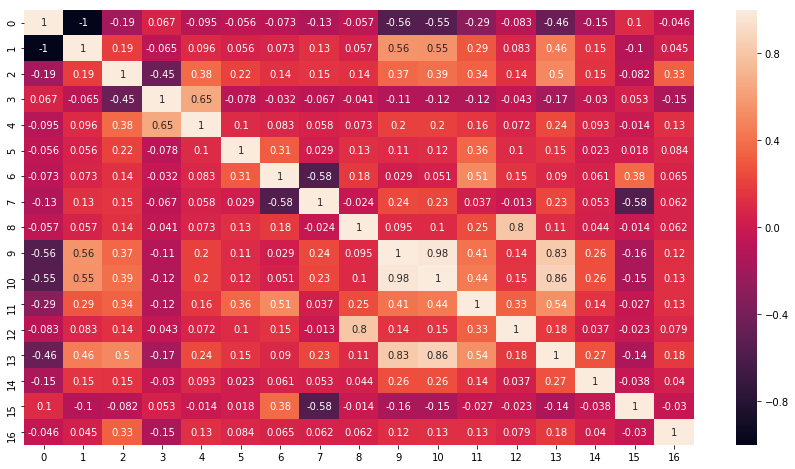

In [52]:
#visualization
ax = plt.axes()
sns.heatmap(np.corrcoef(np.array(data, dtype = np.float)), annot=True, ax=ax)

In [68]:
while True:
    f = True
    c = np.corrcoef(np.array(data, dtype = np.float))
    for i in range(data.shape[0]):
        for j in range(i + 1, data.shape[0]):
            if abs(c[i, j]) >  0.7:
                f = False
                res= j
                break
    if not f:
        bad_cols.append(res)
        data = scipy.delete(data, res, 0)
        break

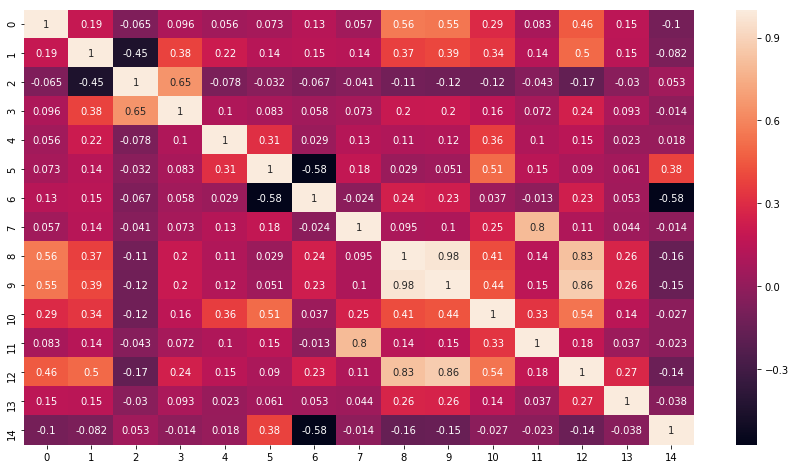

In [70]:
#visualization
ax = plt.axes()
sns.heatmap(np.corrcoef(np.array(data, dtype = np.float)), annot=True, ax=ax)

### Применим PCA

In [71]:
new_data = np.array(data.T, dtype=np.float)
pca1 = PCA(new_data, standardize=True)

print ("Explained variance")
for d in pca1.fracs:
    print (d)
new_data = pca1.Y[:, :-1]
print('Data shape:', new_data.shape)

Explained variance
0.281466172454
0.153889148278
0.111547451116
0.107564266657
0.0780636848548
0.0622617445886
0.0584539017929
0.0407897594757
0.0397249031015
0.0286271841115
0.0154052735147
0.0110732917768
0.00964822273119
0.00143646867558
4.85268712535e-05
Data shape: (9096, 14)


### Посчитаем  аномальность

In [72]:
from operator import itemgetter 

p1=[]
p5=[]
p95=[]
p99=[]

N, K = new_data.shape

for i in range(0,K):
    p1.append(np.percentile(new_data[:, i], 1))
    p5.append(np.percentile(new_data[:, i], 5))
    p95.append(np.percentile(new_data[:, i], 95))
    p99.append(np.percentile(new_data[:, i], 99))

abnormality = {}
for i in range(0, N):
    abnormality[i]=0
    for j in range(0, K):
        c = new_data[i][j]        
        abnormality[i] += 2*(c < p1[j]) + (c < p5[j]) + (c > p95[j]) + 2*(c > p99[j])                

abn_sorted = sorted(abnormality.items(), key=itemgetter(1), reverse=True)
for k, v in abn_sorted[:5]:
    print(k, v)

1471 30
2703 28
3596 28
2844 27
1414 26


(array([  4.14900000e+03,   1.86400000e+03,   8.61000000e+02,
          6.17000000e+02,   3.49000000e+02,   3.09000000e+02,
          2.03000000e+02,   1.45000000e+02,   1.07000000e+02,
          1.11000000e+02,   9.70000000e+01,   4.90000000e+01,
          5.00000000e+01,   3.60000000e+01,   2.10000000e+01,
          1.90000000e+01,   2.20000000e+01,   1.10000000e+01,
          1.40000000e+01,   6.00000000e+00,   1.40000000e+01,
          8.00000000e+00,   7.00000000e+00,   8.00000000e+00,
          7.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.]),
 <a list of 30 Patch objects>)

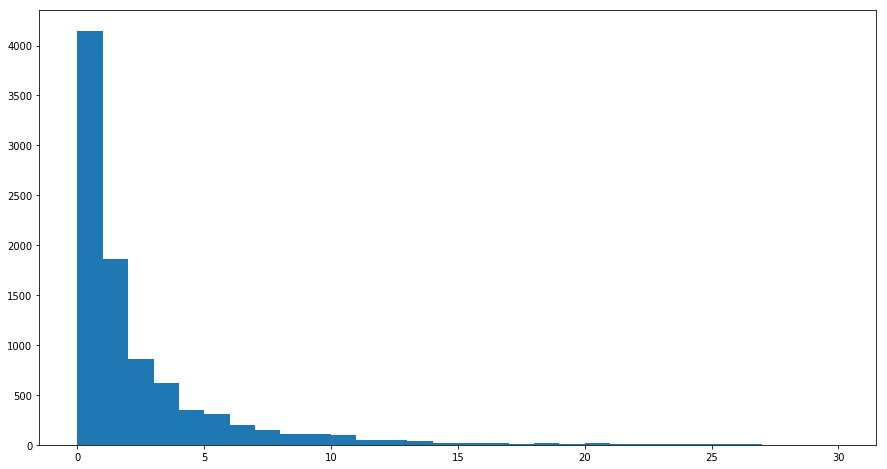

In [73]:
abn_array = list((abnormality.values()))
plt.hist(abn_array, max(abn_array), range=[0,max(abn_array)])

Скажим, что аномальные пользователи все, у кого значение больше 5

In [74]:
abn_users = []
for k, v in abn_sorted:
    if v < 5:
        break
    abn_users.append(k)

### Запустим кластеризацию
Однако, после PCA категориальные признаки исчезли, вернемся на шаг назад -- data_clastirisation


In [81]:
categ_cols = []
for col in range(data_clastirisation.shape[1]):
    unique, counts = np.unique(np.array(data_clastirisation[:, col], dtype=np.str), return_counts=True)        
    if len(unique) > 2:
        continue
    abn_count = np.zeros(2)
    whole_count = np.zeros(2)
    for i in range(data_clastirisation.shape[0]):
        whole_count[int(data_clastirisation[i, col])] += 1
        if i in abn_users:
            abn_count[int(data_clastirisation[i, col])] += 1

In [ ]:
# K-means clustering
nclusters = 8

centroid, label = scipy.cluster.vq.kmeans2(data_clastirisation, nclusters, iter=100, thresh=1e-05, minit='random', missing='warn')
# result of this k-means is unstable, changes when you recalculate the cell


# small trick, explained below
def truevar(x): 
    return np.var(x)

# put abnormality and cluster_id into DataFrame to easily calculate stats:
df_abn = pd.DataFrame(abnormality.values(), columns=[['abn']])
df_label = pd.DataFrame(label, columns=[['cluster_id']])
cluster_stats = pd.concat([df_abn, df_label], axis=1)\
.pivot_table(
    index='cluster_id',
    values='abn',
    aggfunc=[len, np.mean, np.std, truevar]
)

# reorder axis to make cluster_stats look simpler
cluster_stats2 = cluster_stats.reorder_levels([1,0], axis=1)['abn']
cluster_stats2

### Remark: Don't trust anyone

Why did we have to define **truevar** function, which is no more than just a replica of np.var? Why couldn't we run pd.pivot_table with np.var in aggfunc parameter?

Because if you run np.var inside pd.pivot_table, you'll appear to find 
$\sqrt\frac {\sum(x_i - mean)^2}{N-1}$
as a result of calculation, instead of 
$\sqrt\frac {\sum(x_i - mean)^2}{N}$

Problem is in ddof (degrees of freedom) parameter. Looks like in pivot_table python implicitly switches from np.var() to pd.DataFrame.var() function, which has ddof=1 by default:
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.var.html

compare:

print np.var(df_abn)

print df_abn.var()




### Регрессия аномальности
Применим Random Forest

In [86]:
RF = RFC()
GBC = GBC()

features = init_data
labels = np.zeros(init_data.shape[0])
for user in abn_users:
    labels[user] = 1
N_learn = 6000
learn_features = features[:N_learn]
test_features =  features[N_learn:]
learn_labels = labels[:N_learn]
test_labels =  labels[N_learn:]

cur_method = RF
cur_method.fit(learn_features, learn_labels)

predict = cur_method.predict(features)

print ('%s score: test\t%s' % (cur_method.__class__, cur_method.score(test_features, test_labels)))
print ('%s score: learn\t%s' % (cur_method.__class__, cur_method.score(learn_features, learn_labels)))

print ("\nDistribution of labels")
print (np.histogram(labels,2))
print ("\nDistribution of predicted labels")
print (np.histogram(predict,2))



<class 'sklearn.ensemble.forest.RandomForestClassifier'> score: test	0.964793281654
<class 'sklearn.ensemble.forest.RandomForestClassifier'> score: learn	0.996333333333

Distribution of labels
(array([7840, 1256]), array([ 0. ,  0.5,  1. ]))

Distribution of predicted labels
(array([7897, 1199]), array([ 0. ,  0.5,  1. ]))
